In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# dataset

cuda:0


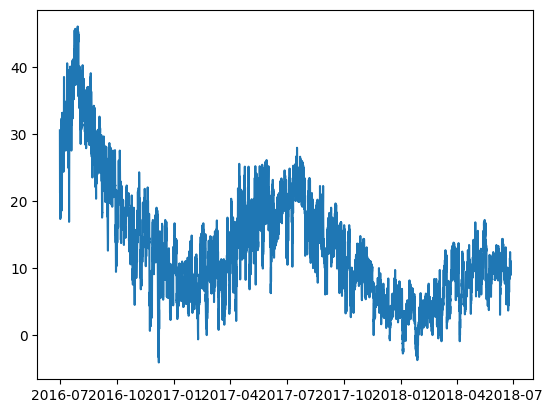

(17320, 101)
(17320, 100) (17320,)
(12124, 100) (3464, 100) (1732, 100)
(12124,) (3464,) (1732,)
(12124, 100, 1) (3464, 100, 1) (1732, 100, 1)
(12124, 1) (3464, 1) (1732, 1)
torch.Size([12124, 100, 1]) torch.Size([3464, 100, 1]) torch.Size([1732, 100, 1])
torch.Size([12124, 1]) torch.Size([3464, 1]) torch.Size([1732, 1])
torch.Size([512, 100, 1]) torch.Size([512, 1])


<ipython-input-5-f2d058f86995>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import os

# functions

def prepare_dataframe_for_lstm(df, n_steps, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, n_steps+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df

# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

batch_size = 512
train_size,val_size,test_size = 0.7,0.2,0.1
lookback = 100
# date_col_name,value_col_name = 'Date','Close'
date_col_name,value_col_name = 'date','OT'
# csvPath = '/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/AMZN.csv'
# csvPath = '/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/ETTh1.csv'
# csvPath = '~/Desktop/own-development-dsa5204-project/data/ETTh1.csv'
csvPath = '/content/drive/MyDrive/dsa5204 project/ETTh1.csv'


data = pd.read_csv(csvPath)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data = data[[date_col_name,value_col_name]]
data[date_col_name] = pd.to_datetime(data[date_col_name])
plt.plot(data[date_col_name], data[value_col_name])
plt.show()


shifted_df = prepare_dataframe_for_lstm(data, lookback, date_col_name, value_col_name)
shifted_df

# format X and y from df and scale it
shifted_df_as_np = shifted_df.to_numpy()
print(shifted_df_as_np.shape)

# normalise the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
print(X.shape, y.shape)
X = dc(np.flip(X, axis=1))

# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]

y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

# pretraining - model

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer

class TransformerModel(nn.Module):
    def __init__(self, num_features=1, d_model=64, dropout=0.1, nhead=4, dim_feedforward=2048,num_layers=2):
        super(TransformerModel, self).__init__()

        self.feature_projection = nn.Linear(num_features, d_model) # projects the input_num_features to d_model reqd for pos encoding
        self.positional_encoder = PositionalEncoding(d_model, dropout)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)


        transformer_decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_decoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)

        self.layer_norm1 = nn.LayerNorm(d_model)

        self.reverse_projection = nn.Linear(d_model,num_features) # projects the d_model to input_num_features to reconstruct the input X

    def forward(self, x):
        x = self.feature_projection(x)
        x = self.positional_encoder(x)
        latent_vector = self.transformer_encoder(x)
        x = self.transformer_decoder(latent_vector)
        x = self.layer_norm1(x)
        reconstructed = self.reverse_projection(x)

        return reconstructed


    def get_latent_vector(self, x):
        x = self.feature_projection(x)
        x = self.positional_encoder(x)
        latent_vector = self.transformer_encoder(x)

        return latent_vector

In [ ]:
# # sample inference

# model = TransformerModel()
# for X,y in train_loader:
#     output = model(X)
#     break

# print(X.shape,output.shape)

# nn.MSELoss()(X,output)

# pretraining - train

In [ ]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
model = TransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, x_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, x_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'pretraining_best_model.pt')
        print(f'model epoch {epoch} saved as pretraining_best_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 0
model epoch 0 saved as pretraining_best_model.pt
Epoch 1/1000, train loss: 0.7891, val loss: 0.2581, time_taken: 6.4
epoch 1
model epoch 1 saved as pretraining_best_model.pt
Epoch 2/1000, train loss: 0.1816, val loss: 0.0198, time_taken: 5.6
epoch 2
model epoch 2 saved as pretraining_best_model.pt
Epoch 3/1000, train loss: 0.1322, val loss: 0.0116, time_taken: 5.7
epoch 3
model epoch 3 saved as pretraining_best_model.pt
Epoch 4/1000, train loss: 0.0528, val loss: 0.0068, time_taken: 5.7
epoch 4
Epoch 5/1000, train loss: 0.0200, val loss: 0.0320, time_taken: 5.7
epoch 5
Epoch 6/1000, train loss: 0.0179, val loss: 0.0167, time_taken: 5.9
epoch 6
Epoch 7/1000, train loss: 0.0116, val loss: 0.0189, time_taken: 5.8
epoch 7
Epoch 8/1000, train loss: 0.0096, val loss: 0.0081, time_taken: 5.9
epoch 8
Epoch 9/1000, train loss: 0.0075, val loss: 0.0084, time_taken: 6.1
epoch 9
model epoch 9 saved as pretraining_best_model.pt
Epoch 10/1000, train loss: 0.0075, val loss: 0.0043, time_taken

KeyboardInterrupt: 

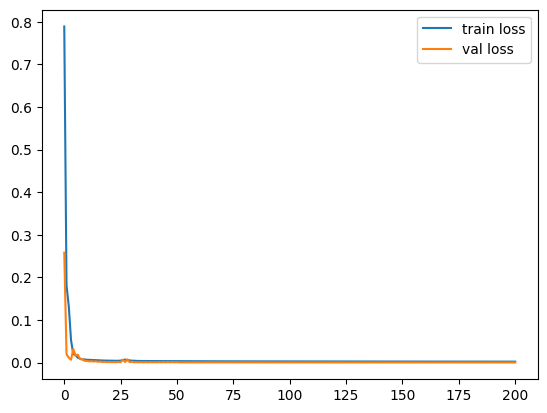

In [ ]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# pretraining - evaluate

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


reconstruction_MSE_loss: 0.0060172053053975105
reconstruction_MAE_loss: 0.054946497082710266


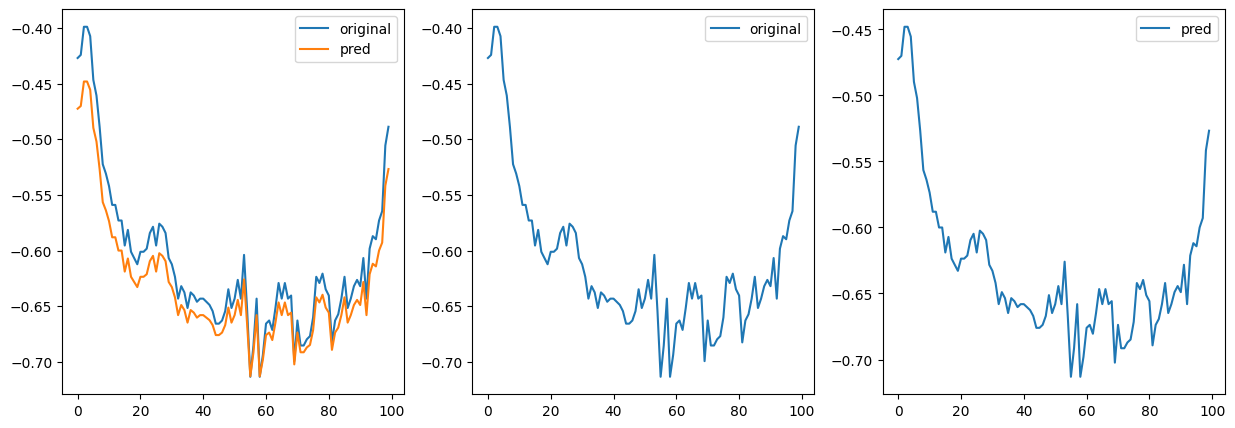

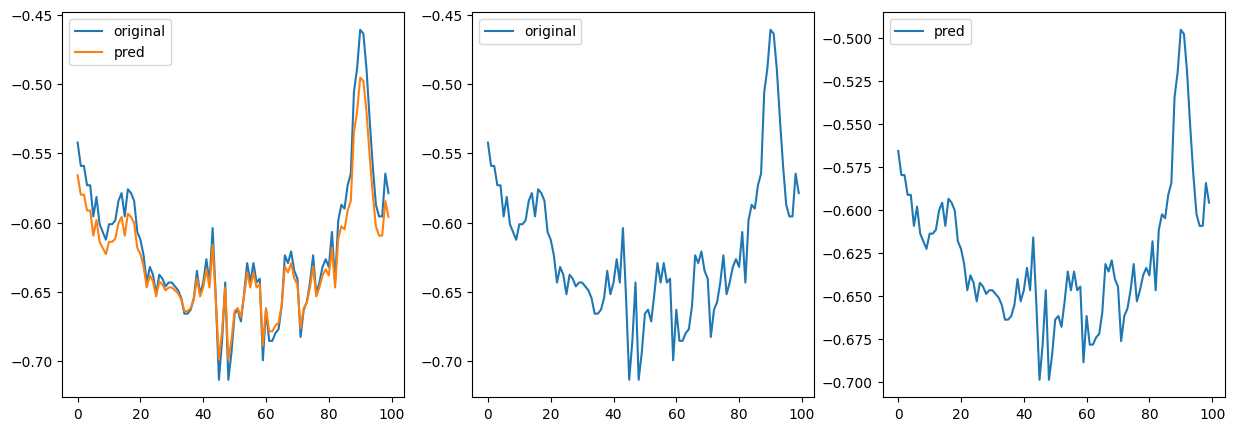

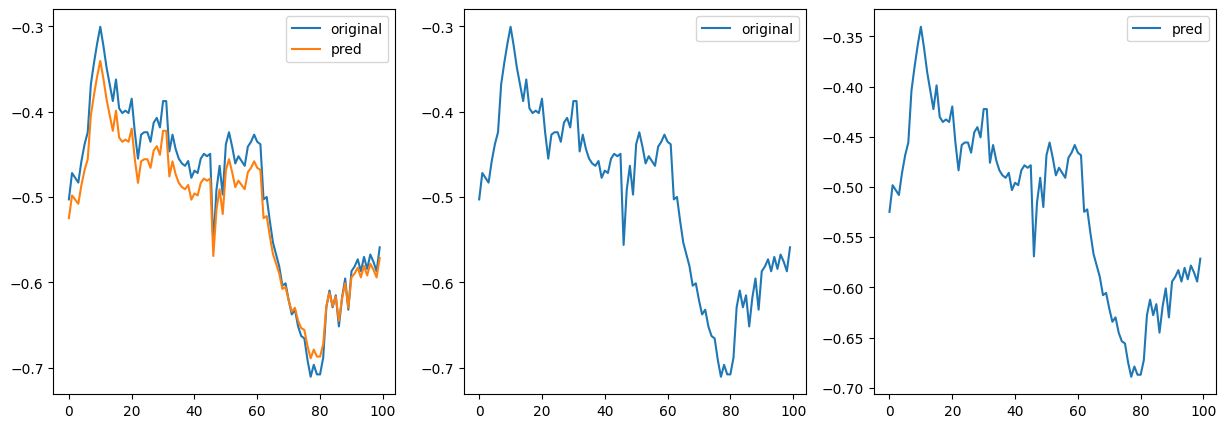

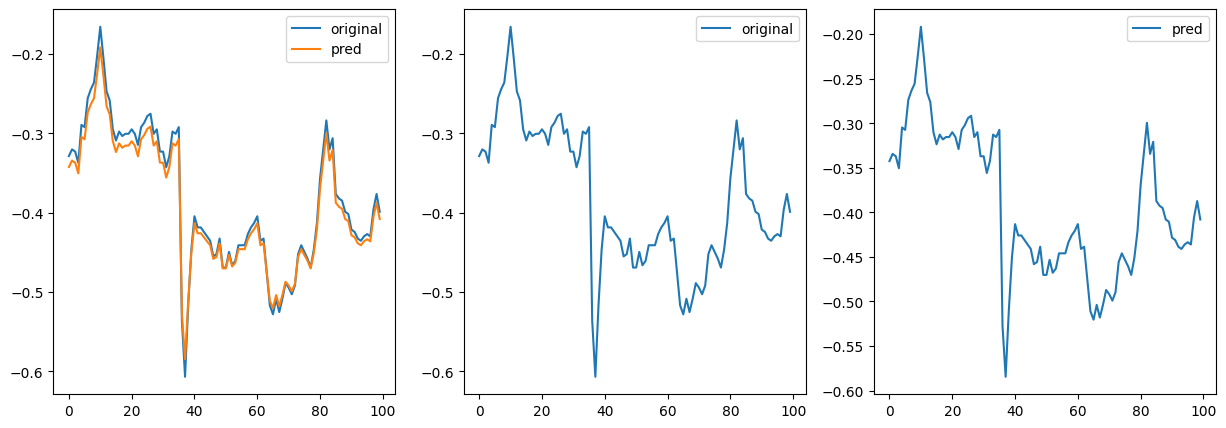

In [ ]:
best_model_path = 'pretraining_best_model.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'


# Load the best model for evaluation
model = TransformerModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()


predictions = model(X_test.to(device))

reconstruction_MSE_loss = nn.MSELoss()(predictions.cpu().detach(),X_test.cpu().detach())
reconstruction_MAE_loss = nn.L1Loss()(predictions.cpu().detach(),X_test.cpu().detach())
print(f'reconstruction_MSE_loss: {reconstruction_MSE_loss}')
print(f'reconstruction_MAE_loss: {reconstruction_MAE_loss}')

# plot reconstruction

indices = [0,10,210,450]
for index in indices:
  fig,ax = plt.subplots(1,3,figsize=(15,5))
  x = X_test.cpu().detach()[index]
  pred = predictions.cpu().detach()[index]

  plt.subplot(1,3,1)
  plt.plot(x,label='original')
  plt.plot(pred,label='pred')
  plt.legend()

  plt.subplot(1,3,2)
  plt.plot(x,label='original')
  plt.legend()

  plt.subplot(1,3,3)
  plt.plot(pred,label='pred')
  plt.legend()

  plt.show()

# finetuning - model

In [ ]:
import torch.nn.functional as F

class FinetuningTransformerModel(nn.Module):
    def __init__(self, d_model=64, num_features=1, seq_len=100, forecasting_window=1):

      super(FinetuningTransformerModel, self).__init__()

      self.seq_len = seq_len
      self.layer_norm = nn.LayerNorm(d_model)
      self.linear1 = nn.Linear(d_model,num_features)
      self.linear2 = nn.Linear(seq_len,1)
      # self.linear3 = nn.Linear(64,1)
      # self.linear3 = nn.Linear(seq_len,1)


    def forward(self, x):
      # input x is the latent vector from the pretraining model latent vector output

      x = self.layer_norm(x)
      x = F.tanh(self.linear1(x))
      x = x.view(x.size(0), -1) # flatten
      # x = F.relu(self.linear1(x))
      x = self.linear2(x) #apply tanh if the values go beyond (-1,1)

      # x = F.relu(self.linear1(x))
      # x = x.view(x.size(0),self.seq_len)
      # # x = F.relu(self.linear2(x))
      # x = self.linear3(x)
      # x = self.linear1(x[:,-1,:])
      # x = F.relu(self.linear1(x))
      # x = x.view(x.size(0),self.seq_len)
      # x = self.linear2(x)
      # x = x[:,:,:1] # since we encoded the original time series information to the first col of the postional encoding vector
      # x = x.view(x.size(0),self.seq_len)
      # x = F.relu(self.linear2(x))
      # x = self.linear3(x)

      return x

In [ ]:
# # sample inference

# model = PretrainingTransformerModel()
# for X,y in train_loader:
#     output = model.get_latent_vector(X)
#     break

# print(X.shape,output.shape)

# nn.MSELoss()(X,output)

# model2 = FinetuningTransformerModel()

# model2(output).shape,y.shape

# finetuning - train

In [ ]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.MSELoss()

# load best pretraining model
best_model_path = 'no_MAE_pretraining_best_model_final.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
pretraining_model = TransformerModel().to(device)
pretraining_model.load_state_dict(torch.load(best_model_path,map_location=device))
pretraining_model.eval()

# intialise finetuning model for forecasting task
model = FinetuningTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        latent_vector = pretraining_model.get_latent_vector(x_batch)

        optimizer.zero_grad()
        outputs = model(latent_vector)

        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            latent_vector = pretraining_model.get_latent_vector(x_batch)

            outputs = model(latent_vector)

            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'finetuning_best_model.pt')
        print(f'model epoch {epoch} saved as finetuning_best_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

cuda
epoch 0
model epoch 0 saved as finetuning_best_model.pt
Epoch 1/1000, train loss: 0.0991, val loss: 0.0475, time_taken: 2.8
epoch 1
model epoch 1 saved as finetuning_best_model.pt
Epoch 2/1000, train loss: 0.0362, val loss: 0.0268, time_taken: 2.7
epoch 2
model epoch 2 saved as finetuning_best_model.pt
Epoch 3/1000, train loss: 0.0210, val loss: 0.0239, time_taken: 2.5
epoch 3
model epoch 3 saved as finetuning_best_model.pt
Epoch 4/1000, train loss: 0.0175, val loss: 0.0169, time_taken: 2.5
epoch 4
Epoch 5/1000, train loss: 0.0163, val loss: 0.0261, time_taken: 2.6
epoch 5
model epoch 5 saved as finetuning_best_model.pt
Epoch 6/1000, train loss: 0.0141, val loss: 0.0153, time_taken: 2.5
epoch 6
Epoch 7/1000, train loss: 0.0133, val loss: 0.0241, time_taken: 2.6
epoch 7
Epoch 8/1000, train loss: 0.0116, val loss: 0.0155, time_taken: 2.6
epoch 8
Epoch 9/1000, train loss: 0.0108, val loss: 0.0226, time_taken: 2.6
epoch 9
Epoch 10/1000, train loss: 0.0099, val loss: 0.0180, time_taken

KeyboardInterrupt: 

# finetuning - evaluate

forecast_MSE_loss: 0.009806607849895954
forecast_MAE_loss: 0.07326018810272217
torch.Size([1732, 1]) torch.Size([1732, 1])


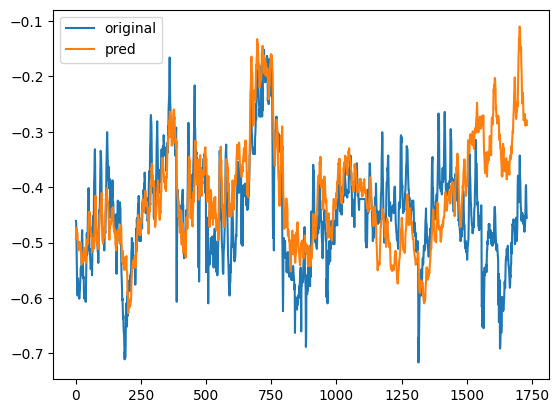

In [ ]:
# load best pretraining model
best_model_path = 'no_MAE_pretraining_best_model_final.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
pretraining_model = TransformerModel().to(device)
pretraining_model.load_state_dict(torch.load(best_model_path,map_location=device))
pretraining_model.eval()

# load best pretraining model
best_model_path = 'finetuning_best_model.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
finetuning_model = FinetuningTransformerModel().to(device)
finetuning_model.load_state_dict(torch.load(best_model_path,map_location=device))
finetuning_model.eval()

latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = finetuning_model(latent_vector)
forecast_MSE_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
print(f'forecast_MSE_loss: {forecast_MSE_loss}')
forecast_MAE_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
print(f'forecast_MAE_loss: {forecast_MAE_loss}')
print(predictions.shape,y_test.shape)

# plot forecasting prediction

y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y,label='original')
plt.plot(pred,label='pred')
plt.legend()

plt.show()